# Logical Examination

```
Author:
    Zach Wolpe
    zachcolinwolpe@gmail.com
    www.zachwolpe.com
```

To address the question:

__Why Does The Autoencoder Deliver Inadequate Performance?__

Consider the structural makeup of an autoencoder:

A probabilistic neural network wherein the response variable is the independent variable and as such attempts to map the some information into a compressed -lower dimensional- space. Probalistic in the sense that the encoded data is represented as a distribution (a Gaussian) and as such the moments of the distribution are learnt.

The weights and biases of the autoencoder are randomized at $0.5$ and $0$ as to be as neutral as possible: being random starting values that bare no influence on the end results.

## Expirment

To assess the poor performance of the autoencoder, analysis is conducted on the early stages of parameter tuning/weight updating. It is plausible the autoencoder:
 - biases towards certain topics, not exploring the space of possibilities properly.
 - overemphasizes the importance of the initial random conditions, making the conditionaly probability of of a topic seletion in $p(Epoch_{t+1}| Epoch_{t})$ unrealistically high.
 
 
## Experiment
The following experiment addresses these concern:

 __Step 1__
 - write a callback function that is executed per epoch. 
 - on execution, perform two actions: sample the learned posterior distribution of the $\theta (Doc \times Topics)$ both once and $10\'000$ times.
 - cease after $100$ epochs as the developement of the $\theta$ probabilities should be readily examinable.
 
__Step 2__
 - Collected data needs be restructured, as the sequence collects data in order of occurance (Epoch --> Document --> Topic) however a simpler to analyse format would constitute (Document --> Epoch --> Topic) as the goal is to investigate the distribution of topic allocation over the iterative process.
 
__Step 3__
 - The reordered data is then plotted and the topic allocation per epoch is aparent. 

In [1]:
%matplotlib inline
import sys, os
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano


from collections import OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

env: THEANO_FLAGS=device=cpu,floatX=float64


# Dataset

20NewsGroups

In [2]:
# The number of words in the vocabulary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))



# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

Loading dataset...
done in 2.000s.
Extracting tf features for LDA...
done in 2.456s.


# Train-Test-Split

In [3]:
# We split the whole documents into training and test sets. 
# The number of tokens in the training set is 480K. 
# Sparsity of the term-frequency document matrix is 0.025%, which implies almost all components in the term-frequency matrix is zero


n_samples_tr = round(tf.shape[0] * 0.7) # testing on 70%
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for testing = {}'.format(docs_te.shape[0]))


n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 7920
Number of docs for testing = 3394
Number of tokens in training set = 384502
Sparsity = 0.0255030303030303


# Specify the Model

In [4]:
n_topics = 10

def logp_lda_doc(beta, theta):
  
  """Returns the log-likelihood function for given documents.
  
  K : number of topics in the model
  V : number of words (size of vocabulary)
  D : number of documents (in a mini-batch)
  
  Parameters
  ----------
  beta : tensor (K x V)
      Word distribution.
  theta : tensor (D x K)
      Topic distributions for the documents.
  """
  
  def ll_docs_f(docs):
    
    dixs, vixs = docs.nonzero()
    vfreqs = docs[dixs, vixs]
    ll_docs = vfreqs * pmmath.logsumexp(
          tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()
      
    # Per-word log-likelihood times no. of tokens in the whole dataset
    return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens

  return ll_docs_f



# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])

with pm.Model() as model:
  theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))),
                   shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9),
                   # do not forget scaling
                   total_size = n_samples_tr)
  beta = Dirichlet('beta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
                 shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
  # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
  doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)
    
    
    
class LDAEncoder:
  """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
  """
  def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
    rng = np.random.RandomState(random_seed)
    self.n_words = n_words
    self.n_hidden = n_hidden
    self.n_topics = n_topics
    self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
    



class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]
    
    

    
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

# Additional Callback

The callback below samples $\theta$ over each epoch in the model, assessing the sampling variation of the $\theta$ as the model is trained allows us to monitor the entire process.

It is possible that certain topics are **Dismissed** after inadequate sample representation in the initial - random - conditions.

In [5]:
tacker_thetas = []
tacker_thetas_1 = []

def my_callback(a,h,i):
    tacker_thetas.append(pm.sample_approx(approx, draws=10000)['theta'].mean(axis=0))
    tacker_thetas_1.append(pm.sample_approx(approx, draws=1)['theta'].mean(axis=0))
    a = a
    h = h
    i = i 
    
  #   tacker_betas.append(approx.model.beta)

In [6]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(100, callbacks=[reduce_rate, my_callback], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t:doc_t_minibatch})

Average Loss = 2.8997e+06: 100%|██████████| 100/100 [45:42<00:00, 25.37s/it]
Finished [100%]: Average Loss = 2.8819e+06


In [9]:
np.shape(tacker_thetas[50:])

(50, 128, 10)

In [24]:
# Save data
import pickle

# 1 sample theta 
pickle_out = open("file_tacker_thetas_1.pkl","wb")
pickle.dump(tacker_thetas_1, pickle_out)
pickle_out.close()

# 10'000 sample theta 
pickle_out = open("file_tacker_thetas.pkl","wb")
pickle.dump(tacker_thetas, pickle_out)
pickle_out.close()


In [25]:
# Reload files 
pickle_in = open("file_tacker_thetas_1.pkl","rb")
tacker_thetas_1 = pickle.load(pickle_in)
print(np.shape(tacker_thetas_1))

pickle_in = open("file_tacker_thetas.pkl","rb")
tacker_thetas = pickle.load(pickle_in)
print(np.shape(tacker_thetas))

(100, 128, 10)
(100, 128, 10)


# Reformat the Matrix

The resulting is matrix is collected in the sequence:
   
**Epoch --> Documents (batch) --> Topics**

This is unavoidable as it is the order the data is generated, however a more useful compolation would be:

**Documents --> Epoch --> Topics**

To more readly assess how topics are allocated to a particular document overtime.

In [26]:

# reshape to (128x100x10) Doc -> epoch -> topic

reshaped_sampled_thetas = []
for i in range(np.shape(tacker_thetas)[1]):
    # for each document
    
    reshaped_sampled_thetas.append(np.array(tacker_thetas)[:,i,:])
    

# perform the same for the 1 theta sample
reshaped_sampled_thetas_1 = []
for i in range(np.shape(tacker_thetas_1)[1]):
    # for each document
    
    reshaped_sampled_thetas_1.append(np.array(tacker_thetas_1)[:,i,:])
    
print(np.shape(reshaped_sampled_thetas))
print(np.shape(reshaped_sampled_thetas_1))

(128, 100, 10)
(128, 100, 10)


In [202]:
reshaped_sampled_thetas[0][0][0]

0.0003393791541217386

# Topic Allocation over 100 Epochs
## 10'000 theta samples

The graphic below randomly selects $12$ documents (of the $128$ used for the first training batch). Each column represents a documents - ranging vertically from $Epoch_0$ to $Epoch_100$. Each column ranges horizontally from $Topic_0$ to $Topic_10$ - since $10$ topics are learnt in this model specification.

first value:  0.06798485615469588

 10'000 Posterior Samples per Epoch (Averaged)


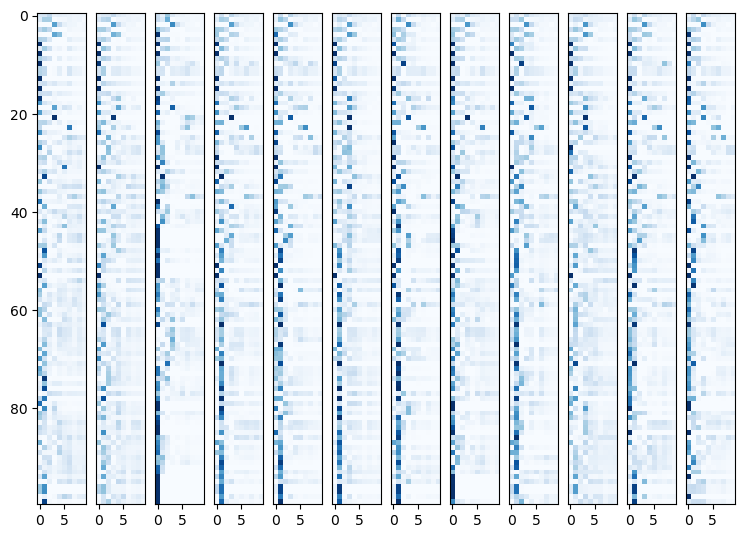

In [228]:
# Shuffle matrix to view a wide spectrum of 
from sklearn.utils import shuffle
shuffle_docs = shuffle(reshaped_sampled_thetas)

fig = plt.figure(figsize=(9,9))
columns = 12                                              # number of randomly selected documents to inspect
rows = np.shape(shuffle_docs)[1]                          # number of Epochs

print('first value: ', shuffle_docs[0][0][0])
print('\n 10\'000 Posterior Samples per Epoch (Averaged)')

plt.style.use('default')

for i in range(1,columns+1):  
    display_doc = shuffle_docs[i]
    fig.add_subplot(1,columns, i)
    if i > 1 :
        plt.yticks([])
    plt.imshow(display_doc, cmap='Blues')
plt.show()

## 10'000 samples conclusion

It appears inherently clear that topic allocation is heavily skewed towards topics $K \in (0,1,2)$ - even in the very early stages of training. Assessing an individual document is futile as this behaviour would be warrented in the case where a single document is dominated by one topic and quickly allocated as such. One would expect a more uniform distribution initially and thereafter topics to be pruned until the true topics emerge. Emperically the first few topics are arbitrarily allotted to nearly all documents.

The same results can be expected in the case of $K=20$ topics.


# Topic Allocation over the 128 batch

Summing the Theta distributions over each topic - over the 100 iterations and over each document - yields the following (highly biased) results.

## Less Epochs

Prehaps a more conservative approach is to look at the distribution of topic allocation over a smaller range of epochs: as, however unlikely, it is possible the topics are adequately learnt after 100 Epochs. Assessing a smaller computational range allows us to confirm the autoencoder does not sufficiently explore the space of possiblities and too readily fixates weightings and biases on initial topics - supporting the finding that the autoencoder performed best on simple ($K$ is small) topics.

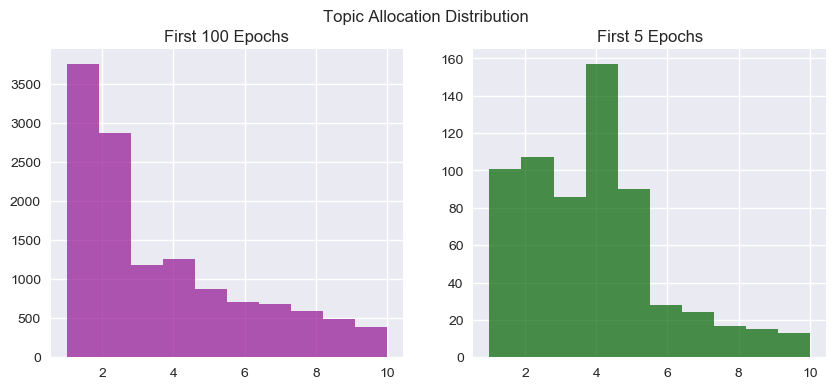

In [213]:
topic_sums = np.sum(np.sum(reshaped_sampled_thetas, axis=1), axis=0)
x = np.arange(1 ,len(topic_sums)+1)


fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.suptitle('Topic Allocation Distribution')

axs[0].title.set_text('First 100 Epochs')
axs[0].hist(np.repeat(x, [int(i) for i in np.round(topic_sums)]),
           color='darkmagenta', alpha=0.65)


# for the first 5 epochs only
topic_sums = np.sum(np.sum(np.array(reshaped_sampled_thetas)[:,:5,:], axis=0), axis=0)
axs[1].title.set_text('First 5 Epochs')
axs[1].hist(np.repeat(x, [int(i) for i in np.round(topic_sums)]),
           color='darkgreen', alpha=0.7);


# Compute the same for the 1 Posterior Sample

In the condition where the intermediate posterior is sampled $10'000$ times, we assess the actual distribution of the learned parameters. 

As we have seen these distributions are cemented with a relatively small series of epochs, assessing a single sample from the posterior, may allow us to gauge the 'randomness' of the posterior sampling process. A large sample ($10'000$ in this experiment) produces an estimate near the true parameter value, where a sample of $1$ should near true randomness. These samples still appear biased towards topics $\in (0,1,2)$.

## Interpretation

It is apparent the Auto-encoder biases the initial wieghts - whether randomly or by design - towards the lower topics. This can be observed as for even the first few epochs the distribution is skewed towards these topics (yielding higher probabilistic values).

Taking a single sample from the distribution neglects the true distribution and only offers a sample statistic. We can see from the code below that the sample is far more likely to come from topics $0 \to 4$ than from topics $5 \to 10$. Further, these initial choices are soon cemented as after $60$ epochs it is very likely to sample from the same distribution as the previous epoch.

first value:  0.000450128179415125

 1 Posterior Sample per Epoch


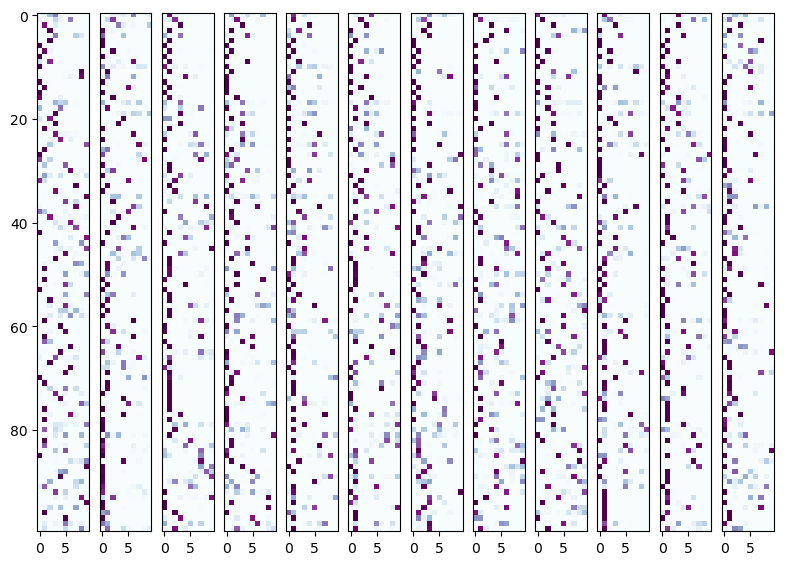

In [223]:
# Shuffle matrix to view a wide spectrum of 
from sklearn.utils import shuffle
shuffle_docs = shuffle(reshaped_sampled_thetas_1)

fig = plt.figure(figsize=(9.5,9))
columns = 12                                              # number of randomly selected documents to inspect
rows = np.shape(shuffle_docs)[1]                          # number of Epochs

print('first value: ', shuffle_docs[0][0][0])
print('\n 1 Posterior Sample per Epoch')

plt.style.use('default')
for i in range(1,columns+1):  
    display_doc = shuffle_docs[i]
    fig.add_subplot(1,columns, i)
    if i > 1 :
        plt.yticks([])
    plt.imshow(display_doc, cmap='BuPu')
  
plt.show()

# cividis, viridis, Blues, BuPu

# Theta Value Updating

To further investigate the probabilistic vlaues of the learned $\theta$ distribution, the following function returns the theta distribution per epoch for $5$ documents.

More sophisticated analysis may include computing the correlation between Epochs for a given document, or conditionaly probabilities of $P(Epoch_t | Epoch_{t-1})$.

In [28]:
np.round(tacker_thetas_1[0][0], 3)


for i in range(5):
    # for the first 5 EPOCHS
    
    for j in range(5):
        # for the first 5 documents 
    
        print('Document:', i+1, '\n Epoch: ',j+1)
        print(np.round(tacker_thetas_1[j][i], 3))
        print('\n')
    
    print('\n\n')

Document: 1 
 Epoch:  1
[0.    0.302 0.036 0.    0.001 0.201 0.01  0.331 0.118 0.   ]


Document: 1 
 Epoch:  2
[0.    0.018 0.    0.003 0.008 0.161 0.015 0.    0.122 0.672]


Document: 1 
 Epoch:  3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Document: 1 
 Epoch:  4
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Document: 1 
 Epoch:  5
[0.007 0.    0.    0.    0.993 0.    0.    0.    0.    0.   ]





Document: 2 
 Epoch:  1
[0.032 0.064 0.002 0.882 0.    0.003 0.    0.001 0.005 0.01 ]


Document: 2 
 Epoch:  2
[0.007 0.716 0.01  0.    0.006 0.004 0.005 0.196 0.055 0.   ]


Document: 2 
 Epoch:  3
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Document: 2 
 Epoch:  4
[0.048 0.952 0.    0.    0.    0.    0.    0.    0.    0.   ]


Document: 2 
 Epoch:  5
[0.466 0.    0.    0.    0.534 0.    0.    0.    0.    0.   ]





Document: 3 
 Epoch:  1
[0.004 0.    0.015 0.094 0.001 0.268 0.134 0.028 0.272 0.185]


Document: 3 
 Epoch:  2
[0.019 0.138 0.557 0.    0.    0.005 0.192 0.    0.075 0.013]


Document: 3 
 Epoch:  3
[0. 